In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

Matplotlib created a temporary config/cache directory at /var/folders/_n/4rn71s9d0kbcfsx7vgnkblrc0000gn/T/matplotlib-8iffzggz because the default path (/Users/zhenhan/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
train = pd.read_csv("/Users/zhenhan/Desktop/深度学习/data/房屋数据（2011.8-2015.6）.csv")
train_isna = []
for col in train.columns:
    if train[col].isna().sum() / train.shape[0] > 0.4:
        train_isna.append(col)
df = train.drop(train_isna, axis=1)
df_num = df.select_dtypes(include=['int64', 'float64'])
df_obj = df.select_dtypes(include=['object'])
df_num_means = df_num.median()
df_num = df_num.fillna(df_num_means)
df_num.isna().sum().value_counts()
df_num = df_num.iloc[:,1:]
df_obj = df_obj.iloc[:,1:]
df_obj_map = {"poor":0, "no data":2, "satisfactory":2, "good":3, "excellent":4}
df_obj["ecology"] = df_obj["ecology"].map(df_obj_map)
label_encoder = LabelEncoder()
df_obj['sub_area'] = label_encoder.fit_transform(df_obj['sub_area'])
df_obj = pd.get_dummies(df_obj, columns=df_obj.columns[2:14], prefix=df_obj.columns[2:14])
df_obj = pd.get_dummies(df_obj, columns=['product_type'], prefix=['product_type'])
target_column = df_num.columns[-1]
# for col in df_num.columns:
#     correlation = df[col].corr(df[target_column])
#     if abs(correlation) <= 0.05:
#         df_num = df_num.drop(col, axis=1)
data = pd.concat([df_num, df_obj], axis=1)
X = data.drop('price_doc', axis=1)
y = data['price_doc']
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.66, random_state=42)

0:	learn: 4612047.0570025	test: 4303171.7651076	best: 4303171.7651076 (0)	total: 72.4ms	remaining: 57.8s
20:	learn: 2960100.1974174	test: 2792238.1927904	best: 2792238.1927904 (20)	total: 419ms	remaining: 15.5s
40:	learn: 2692019.7364337	test: 2635824.6226902	best: 2635824.6226902 (40)	total: 743ms	remaining: 13.8s
60:	learn: 2578715.1430609	test: 2619871.6286922	best: 2617058.8340013 (58)	total: 1.07s	remaining: 12.9s
80:	learn: 2503092.9891802	test: 2606058.0627928	best: 2606058.0627928 (80)	total: 1.46s	remaining: 12.9s
100:	learn: 2439044.6827245	test: 2587781.5398652	best: 2587781.5398652 (100)	total: 1.77s	remaining: 12.3s
120:	learn: 2386151.7486367	test: 2582681.3476998	best: 2581849.3863219 (108)	total: 2.1s	remaining: 11.8s
140:	learn: 2336966.0294486	test: 2580735.2386832	best: 2580735.2386832 (140)	total: 2.44s	remaining: 11.4s
160:	learn: 2286358.8482479	test: 2575586.2591560	best: 2574521.6164217 (149)	total: 2.79s	remaining: 11.1s
180:	learn: 2244931.1701653	test: 257203

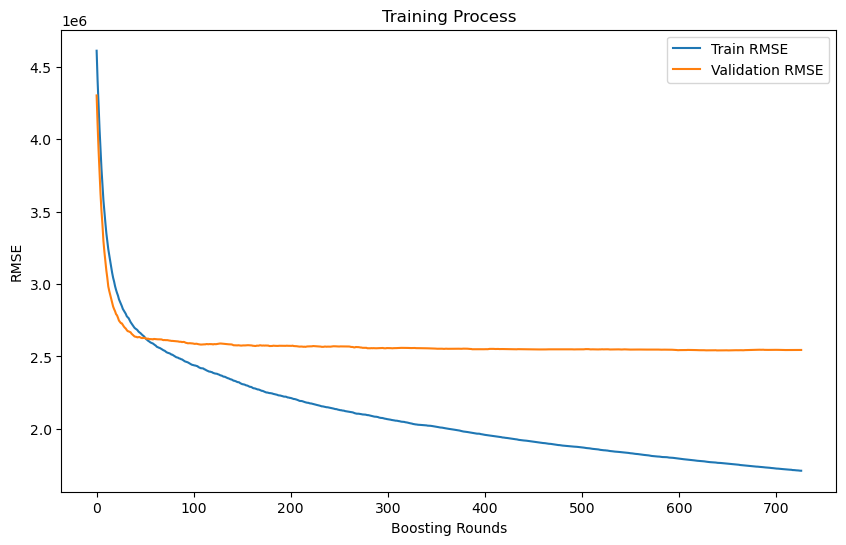

In [3]:
train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val)

params = {
    'depth': 6,  
    'learning_rate': 0.1,
    'colsample_bylevel': 0.8,
    'subsample': 0.8
}

num_round = 800

history = {'training': {'rmse': []}, 'valid_1': {'rmse': []}}

model = CatBoostRegressor(
    iterations=num_round,
    eval_metric='RMSE',
    train_dir='catboost_info',
    loss_function='RMSE',
    random_state=42,
    **params
)

model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    verbose=20,
    early_stopping_rounds=80
)

history['training']['rmse'] = model.evals_result_['learn']['RMSE']
history['valid_1']['rmse'] = model.evals_result_['validation']['RMSE']

predictions = model.predict(X_test)

rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.figure(figsize=(10, 6))
plt.plot(history['training']['rmse'], label='Train RMSE')
plt.plot(history['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training Process')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, make_scorer

train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val)

params_test1={
    'depth': range(5,15,1), 
}

params_test2={
    'depth': [9],
    'boosting_type': ['Ordered', 'Plain', 'RandomForest'],
    # 'feature_border_type': ['GreedyLogSum', 'UniformPartition']
}
params_test3={
    'depth': [9],
    'boosting_type': ['Plain'],
    'feature_border_type': ['GreedyLogSum'],
    'bagging_temperature': np.arange(0.1, 1, 0.2),
    'random_strength': np.arange(0.5, 2, 0.3),
    'l2_leaf_reg': np.arange(1, 4, 0.5)
}

params_test4={
    'depth': [9],
    'boosting_type': ['Plain'],
    'feature_border_type': ['GreedyLogSum'],
    'bagging_temperature': [0.1, 0.3, 0.6, 0.9],
    'random_strength': [0.5],
    'l2_leaf_reg': [2.5]
}


num_round = 1000


model = CatBoostRegressor(
    iterations=num_round,
    eval_metric='RMSE',
    train_dir='catboost_info',
    loss_function='RMSE',
    learning_rate=0.03,
    use_best_model=True,
    verbose=200,
    early_stopping_rounds=100,
    random_seed=42
)

grid_search = GridSearchCV(estimator=model,
                           param_grid=params_test4,
                           cv=5,
                           scoring=make_scorer(mean_squared_error, greater_is_better=False),
                           verbose=2,
                           n_jobs=-1)




grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)])

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

predictions = best_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error on Validation:", rmse)

r2 = r2_score(y_test, predictions)
print("R-squared on Validation:", r2)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 4738996.5261585	test: 4451293.8752284	best: 4451293.8752284 (0)	total: 368ms	remaining: 6m 7s
0:	learn: 4814573.6070436	test: 4451829.1942869	best: 4451829.1942869 (0)	total: 493ms	remaining: 8m 12s
0:	learn: 4809826.3524856	test: 4452926.1594060	best: 4452926.1594060 (0)	total: 1.25s	remaining: 20m 47s
0:	learn: 4809826.3524856	test: 4452926.1594060	best: 4452926.1594060 (0)	total: 1.27s	remaining: 21m 7s
0:	learn: 4763987.7202157	test: 4452211.4324033	best: 4452211.4324033 (0)	total: 1.29s	remaining: 21m 32s
0:	learn: 4678710.3974245	test: 4453456.0986238	best: 4453456.0986238 (0)	total: 1.31s	remaining: 21m 53s
0:	learn: 4678710.3974245	test: 4453456.0986238	best: 4453456.0986238 (0)	total: 1.4s	remaining: 23m 13s
0:	learn: 4763987.7202157	test: 4452211.4324033	best: 4452211.4324033 (0)	total: 1.45s	remaining: 24m 5s
0:	learn: 4738996.5261585	test: 4451293.8752284	best: 4451293.8752284 (0)	total: 1.49s	remaining: 